# Final Project

### 獲取歷史資料

In [2]:
from finlab.data import Data
import pandas as pd
import talib

data = Data()

rev = data.get("當月營收")
close = data.get("收盤價")

rev.index = rev.index.shift(5, "d")

In [3]:
data

### 計算features

In [5]:
def bias(n):
    return close / close.rolling(n, min_periods=1).mean()

def acc(n):
    return close.shift(n) / (close.shift(2*n) + close) * 2

def rsv(n):
    l = close.rolling(n, min_periods=1).min()
    h = close.rolling(n, min_periods=1).max()
    
    return (close - l) / (h - l)

def mom(n):
    return (rev / rev.shift(1)).shift(n)

features = {
    'mom1': mom(1),
    'mom2': mom(2),
    'mom3': mom(3),
    'mom4': mom(4),
    'mom5': mom(5),
    'mom6': mom(6),
    'mom7': mom(7),
    'mom8': mom(8),
    'mom9': mom(9),
    
    'bias5': bias(5),
    'bias10': bias(10),
    'bias20': bias(20),
    'bias60': bias(60),
    'bias120': bias(120),
    'bias240': bias(240),
    
    'acc5': acc(5),
    'acc10': acc(10),
    'acc20': acc(20),
    'acc60': acc(60),
    'acc120': acc(120),
    'acc240': acc(240),
    
    'rsv5': rsv(5),
    'rsv10': rsv(10),
    'rsv20': rsv(20),
    'rsv60': rsv(60),
    'rsv120': rsv(120),
    'rsv240': rsv(240),
}


### 製作dataset

##### 設定買賣頻率

In [6]:
every_month = rev.index
every_month

DatetimeIndex(['2005-02-15', '2005-03-15', '2005-04-15', '2005-05-15',
               '2005-06-15', '2005-07-15', '2005-08-15', '2005-09-15',
               '2005-10-15', '2005-11-15',
               ...
               '2021-04-15', '2021-05-15', '2021-06-15', '2021-07-15',
               '2021-08-15', '2021-09-15', '2021-10-15', '2021-11-15',
               '2021-12-15', '2022-01-15'],
              dtype='datetime64[ns]', name='date', length=204, freq=None)

##### 將dataframe 組裝起來

In [7]:
# features['bias20'].reindex(every_month, method='ffill')

for name, f in features.items():
    features[name] = f.reindex(every_month, method='ffill')

In [8]:
for name, f in features.items():
    features[name] = f.unstack()

In [9]:
import pandas as pd
dataset = pd.DataFrame(features)

In [10]:
feature_names = list(dataset.columns)

### 新增 label

In [11]:
from finlab import ml

ml.add_profit_prediction(dataset)
ml.add_rank_prediction(dataset)

### 刪除太大太小的歷史資料

In [12]:
print(dataset.shape)

def drop_extreme_case(dataset, feature_names, thresh=0.01):
    
    extreme_cases = pd.Series(False, index=dataset.index)
    for f in feature_names:
        tf = dataset[f]
        extreme_cases = extreme_cases | (tf < tf.quantile(thresh)) | (tf > tf.quantile(1-thresh))
    dataset = dataset[~extreme_cases]
    return dataset

dataset_drop_extreme_case = drop_extreme_case(dataset, 
    ['bias60', 'bias120', 'bias240', 'mom1', 'mom2', 'mom3', 'mom4', 'mom5', 'mom6'], thresh=0.01)

print(dataset_drop_extreme_case.shape)

(409224, 29)
(382836, 29)


In [13]:
dataset_dropna = dataset_drop_extreme_case.dropna(how='any')
dataset_dropna = dataset_dropna.reset_index().set_index("date")

In [14]:
dataset_drop_extreme_case.index.get_level_values("date")

DatetimeIndex(['2005-02-15', '2005-03-15', '2005-04-15', '2005-05-15',
               '2005-06-15', '2005-07-15', '2005-08-15', '2005-09-15',
               '2005-10-15', '2005-11-15',
               ...
               '2021-03-15', '2021-04-15', '2021-05-15', '2021-06-15',
               '2021-08-15', '2021-09-15', '2021-10-15', '2021-11-15',
               '2021-12-15', '2022-01-15'],
              dtype='datetime64[ns]', name='date', length=382836, freq=None)

In [15]:
dataset_train = dataset_dropna.loc[:'2019']
dataset_test = dataset_dropna.loc['2020':]

### 神經網路模型

In [16]:
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers

os.environ['KMP_DUPLICATE_LIB_OK']='True'

model = keras.models.Sequential()
model.add(layers.Dense(100, activation='relu',
                      input_shape=(len(feature_names),),
                      kernel_initializer=initializers.he_normal(seed=0)))
model.add(layers.Dense(100, activation='relu',
                      kernel_initializer=initializers.he_normal(seed=0)))
model.add(layers.Dropout(0.7))
model.add(layers.Dense(1, activation='sigmoid'))


model.summary()

model.compile(loss='mean_squared_error',
              optimizer="adam",)

print('start fitting')
history = model.fit(dataset_train[feature_names], dataset_train['rank'],
                    batch_size=1000,
                    epochs=225,
                    verbose=1,
                    validation_split=0.1, )


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               2800      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 13,001
Trainable params: 13,001
Non-trainable params: 0
_________________________________________________________________
start fitting
Epoch 1/225
136/136 [==============================] - ETA: 0s - loss: 0.182 - ETA: 0s - loss: 0.134 - ETA: 0s - loss: 0.109 - ETA: 0s - loss: 0.100 - ETA: 0s - loss: 0.095 - ETA: 0s - loss: 0.091 - 0s 3ms/step - loss: 0.0906 - val_loss

### 結果

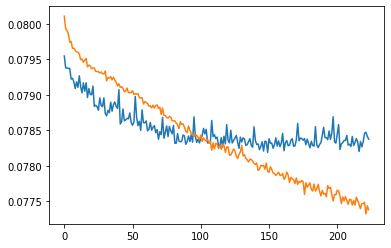

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['val_loss'][1:])
plt.plot(history.history['loss'][1:])

### lightgbm Model

In [18]:
import lightgbm as lgb
cf = lgb.LGBMRegressor(n_estimators=500)
cf.fit(dataset_train[feature_names].astype(float), dataset_train['rank'])

LGBMRegressor(n_estimators=500)

### Random Forest Model

In [20]:
from sklearn.ensemble import RandomForestRegressor

cf2 = RandomForestRegressor(n_estimators=100)
cf2.fit(dataset_train[feature_names].astype(float), dataset_train['rank'])

RandomForestRegressor()

<AxesSubplot:xlabel='Value', ylabel='Feature'>

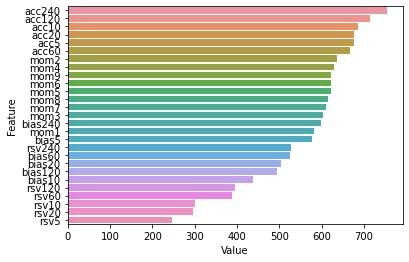

In [21]:
feature_imp = pd.DataFrame(zip(cf.feature_importances_, feature_names), 
                           columns=['Value','Feature']).sort_values('Value', ascending=False)
feature_imp

%matplotlib inline
import seaborn as sns
sns.barplot(x="Value", y="Feature", data=feature_imp)

### Ensemble learning

In [22]:
dataset_drop = dataset.dropna(subset=feature_names+['return'])

vals = model.predict(dataset_drop[feature_names].astype(float))
dataset_drop['result1'] = pd.Series(vals.swapaxes(0,1)[0], dataset_drop.index)

vals = cf.predict(dataset_drop[feature_names].astype(float))
dataset_drop['result2'] = pd.Series(vals, dataset_drop.index)

vals = cf2.predict(dataset_drop[feature_names].astype(float))
dataset_drop['result3'] = pd.Series(vals, dataset_drop.index)

dataset_drop = dataset_drop.reset_index().set_index("date")

C:\Users\xunzh\miniconda3\envs\finlab\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\xunzh\miniconda3\envs\finlab\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\xunzh\miniconda3\envs\finlab\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

# backtest

<AxesSubplot:xlabel='date'>

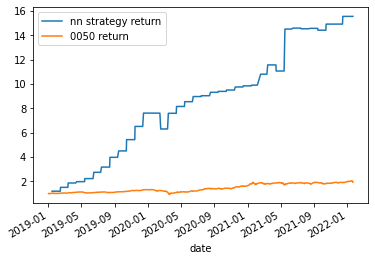

In [25]:
import math


dates = sorted(list(set(dataset_drop.index)))

rs = []
for d in dates:
    
    dataset_time = dataset_drop.loc[d]
    
    dataset_time = drop_extreme_case(dataset_time, 
        ['bias60', 'bias120', 'bias240', 'mom1', 'mom2', 'mom3', 'mom4', 'mom5', 'mom6'], thresh=0.01)
    
    rank = dataset_time['result1'] + dataset_time['result2'] + dataset_time['result3'] 
    
    condition = (rank >= rank.nlargest(20).iloc[-1]) 
    r = dataset_time['return'][condition].mean()

    rs.append(r * (1-3/1000-1.425/1000*2))

rs = pd.Series(rs, index=dates)['2019':].cumprod()

s0050 = close['0050']['2019':]

pd.DataFrame({'nn strategy return':rs.reindex(s0050.index, method='ffill'), '0050 return':s0050/s0050[0]}).plot()



### 當月持股狀況

In [24]:
dataset.index.levels[1]

DatetimeIndex(['2005-02-15', '2005-03-15', '2005-04-15', '2005-05-15',
               '2005-06-15', '2005-07-15', '2005-08-15', '2005-09-15',
               '2005-10-15', '2005-11-15',
               ...
               '2021-04-15', '2021-05-15', '2021-06-15', '2021-07-15',
               '2021-08-15', '2021-09-15', '2021-10-15', '2021-11-15',
               '2021-12-15', '2022-01-15'],
              dtype='datetime64[ns]', name='date', length=204, freq=None)

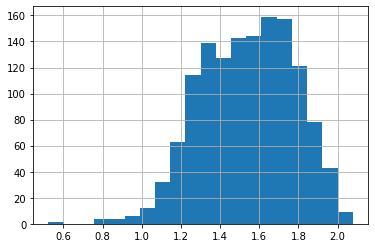

In [27]:
# get the latest dataset
last_date = "2019-07-15"#dataset.index.levels[1].max()
is_last_date = dataset.index.get_level_values('date') == last_date
last_dataset = dataset[is_last_date].copy()


last_dataset = drop_extreme_case(last_dataset, 
    ['bias60', 'bias120', 'bias240', 'mom1', 'mom2', 'mom3'], thresh=0.01)


# remove NaN testcases
last_dataset = last_dataset.dropna(subset=feature_names)

# predict

vals = model.predict(last_dataset[feature_names].astype(float))
last_dataset['result1'] = pd.Series(vals.swapaxes(0,1)[0], last_dataset.index)

vals = cf.predict(last_dataset[feature_names].astype(float))
last_dataset['result2'] = pd.Series(vals, last_dataset.index)

vals = cf2.predict(last_dataset[feature_names].astype(float))
last_dataset['result3'] = pd.Series(vals, last_dataset.index)

# calculate score

rank = last_dataset['result1'] + last_dataset['result2'] + last_dataset['result3']
condition = (rank >= rank.nlargest(20).iloc[-1]) 

# plot rank distribution
rank.hist(bins=20)


# show the best 20 stocks
slist1 = rank[condition].reset_index()['stock_id']

# 平均分配資產於股票之中

In [28]:
close = data.get("收盤價")

money = 1000000
stock_prices = close[rank[condition].reset_index()['stock_id']].iloc[-1]


print("股票平分張數:")
money / len(stock_prices) / stock_prices / 1000


股票平分張數:


stock_id
1785    1.024590
1809    3.597122
2316    1.470588
3105    0.147710
3144         NaN
3206    1.763668
3324    0.239234
3380    1.642036
3444    0.931099
4154    1.199041
4192    1.724138
4506    0.764526
5403    0.726744
5493    1.170960
6203    0.673854
6263    0.709220
6417         NaN
6472    0.291545
8431    0.724638
8467    1.314060
Name: 2022-01-21 00:00:00, dtype: float64